In [4]:
'''Train a Bidirectional LSTM on the IMDB sentiment classification task.
Output after 4 epochs on CPU: ~0.8146
Time per epoch on CPU (Core i7): ~150s.
'''
# https://github.com/changhuixu/LSTM-sentiment-analysis/tree/35ed3660cb11fb7a366230331be5d747d63bc492

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, concatenate
import json
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score, recall_score


max_features = 22142
maxlen = 50  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
path  = "/content/drive/MyDrive/Kaggle 2 data/"



In [5]:
print('Loading data...')
# (X_train, y_train), (X_test, y_test) = imdbReviews.load_data(nb_words=max_features)

with open(path+"processed strings_lem (1).json") as train:
    training = json.load(train)
with open(path+"processed strings_lem_test.json") as test:
    testing = json.load(test)

with open(path+"processed_words_lem_dict_sorted (1).json") as dictt:
    words_dict = json.load(dictt)

train_results = pd.read_csv(path+"train_results.csv")
train_results = list(train_results['target'])

Loading data...


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
new_data = []
for i in range(len(train_results)):
    if train_results[i] == 'neutral':
        res = 1
    elif train_results[i] == 'negative':
        res = 0
    elif train_results[i] == 'positive':
        res = 2
    new_data.append(res)

words = dict((value, idx) for idx, value in enumerate(list(words_dict.keys())))

training = [[words[w] for w in sent.split(" ") if words[w]<22142] for sent in training]
testing = [[words[w] for w in sent.split(" ") if (w in words and words[w]<22142)] for sent in testing]

In [8]:
# print("max sentence length:")
# print(max([len(x) for x in training + testing]))
X_train = training[:900000]
X_test = training[900000:1000000]
y_train = new_data[:900000]
y_test = new_data[900000:1000000]



print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

900000 train sequences
100000 test sequences


In [9]:
print("Pad sequences (samples x time)")

X_train = pad_sequences(X_train, maxlen=maxlen)
# print(type(X_train))
testing = pad_sequences(testing, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


# this is the placeholder tensor for the input sequences
sequence = Input(shape=(maxlen,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size 128
embedded = Embedding(max_features, 128, input_length=maxlen)(sequence)

# apply forwards LSTM
forwards = LSTM(64)(embedded)
# apply backwards LSTM
backwards = LSTM(64, go_backwards=True)(embedded)

# concatenate the outputs of the 2 LSTMs
merged = concatenate([forwards, backwards], axis=-1)
after_dp = Dropout(0.1)(merged)
output = Dense(3, activation='softmax', kernel_initializer='he_uniform', kernel_regularizer='l2')(after_dp)

model = Model(sequence, output)

from keras.optimizers import Adam
# try using different optimizers and different optimizer configs
model.compile(Adam(lr=0.002), 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


Pad sequences (samples x time)
X_train shape: (900000, 50)
X_test shape: (100000, 50)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:

X_train = np.asarray(X_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
# y_test = np.asarray(y_test).astype(np.float32)

print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test])


Train...
Epoch 1/10
28125/28125 [==============================] - 266s 9ms/step - loss: 0.4653 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.4448 - val_sparse_categorical_accuracy: 0.7947
Epoch 2/10
28125/28125 [==============================] - 255s 9ms/step - loss: 0.4296 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.4445 - val_sparse_categorical_accuracy: 0.7960
Epoch 3/10
28125/28125 [==============================] - 254s 9ms/step - loss: 0.4148 - sparse_categorical_accuracy: 0.8118 - val_loss: 0.4440 - val_sparse_categorical_accuracy: 0.7963
Epoch 4/10
28125/28125 [==============================] - 249s 9ms/step - loss: 0.4043 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.4482 - val_sparse_categorical_accuracy: 0.7948
Epoch 5/10
28125/28125 [==============================] - 251s 9ms/step - loss: 0.3970 - sparse_categorical_accuracy: 0.8218 - val_loss: 0.4509 - val_sparse_categorical_accuracy: 0.7946
Epoch 6/10
28125/28125 [==============================] - 248

In [11]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.002,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [12]:
print(history.history.keys())
print(history.history['val_loss'])
print(history.history['loss'])
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
[0.4448067247867584, 0.4445349872112274, 0.44401121139526367, 0.4481925368309021, 0.4509207308292389, 0.4549025297164917, 0.45119526982307434, 0.4522225260734558, 0.4603100121021271, 0.45694586634635925]
[0.4652702212333679, 0.4296424984931946, 0.4148085117340088, 0.40430527925491333, 0.39703625440597534, 0.391164630651474, 0.38615527749061584, 0.3827466070652008, 0.37949809432029724, 0.3781372904777527]


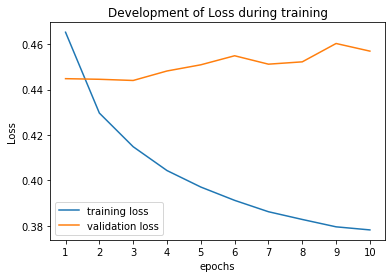

In [13]:
import matplotlib.pyplot as plt


plt.figure()

plt.xticks(range(1,11))
plt.plot(list(range(1, len(loss_list)+1, 1)), loss_list, label="training loss")
plt.plot(list(range(1, len(val_loss_list)+1, 1)), val_loss_list, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Development of Loss during training")
plt.legend()
# plt.close()

[0.7818255424499512, 0.8025722503662109, 0.8117789030075073, 0.8177700042724609, 0.821785569190979, 0.8255422115325928, 0.8283266425132751, 0.8304177522659302, 0.832581102848053, 0.8332377672195435]
[0.7946500182151794, 0.7960399985313416, 0.7962899804115295, 0.7947800159454346, 0.7945799827575684, 0.7944300174713135, 0.7932400107383728, 0.7927799820899963, 0.7922700047492981, 0.7906000018119812]


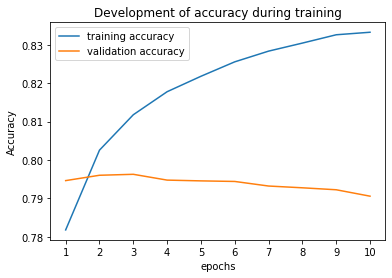

In [14]:
print(acc)
print(val_acc)
plt.figure()

plt.xticks(range(1,11))
plt.plot(list(range(1, len(acc)+1, 1)), acc, label="training accuracy")
plt.plot(list(range(1, len(val_acc)+1, 1)), val_acc, label="validation accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Development of accuracy during training")
plt.legend()

In [15]:

y_prob = model.predict(X_test)
# print(y_prob)
pred = y_prob.argmax(axis=-1)
print("validation accuracy is: ")
# print(pred)
acc = accuracy_score(y_test, pred)
print(acc)

3125/3125 [==============================] - 12s 3ms/step
validation accuracy is: 
0.7906


In [16]:


testing = np.asarray(testing).astype(np.float32)
prob = model.predict(testing)
prediction = prob.argmax(axis=-1)
df = pd.DataFrame(prediction, columns =['target'])
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'id'})
df.to_csv("prediction_7977,dropout0.1,3epochs.csv", index=False)



17506/17506 [==============================] - 62s 3ms/step
